# Fitting distribution of workplace size

This is an exercise on fitting real, in this case the distribution of company sizes in Denmark (in terms of FTE workers). This distribution was used in relation to Covid-19 modelling, but is in itself interresting.

You only need to consider the first two columns (size and frequency), as the rest is just derived from there.

NOTE: When extracting data from Statistics Denmark (DK: Danmarks Statistik), bins with less than 5 entries are by law not allowed to be revealed (to protect from ability to single out persons/companies), and are shown as NaN (Not a Number).

### References
Data from Statistics Denmark (contact: Laust Hvas Mortensen)

### Authors
Troels C. Petersen (NBI, petersen@nbi.dk)

### Date
04-12-2023 (latest update)

***

In [1]:
from __future__ import division, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from iminuit import Minuit
from scipy import stats
import pandas as pd
from scipy import interpolate

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

In [2]:
save_plots = False   # For now, don't save plots (once you trust your code, switch on)
verbose = True       # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10        # But only print a lot for the first 10 random numbers

### Load data

In [3]:
data_test = pd.read_csv("TableData_Denmark2020.txt", header=0, sep=' ', index_col=0)

print(data_test.head(10))
print("...")
print(data_test.tail(10))

# Two 1D arrays:
Nworkers = np.arange(1, 200)
Ncompanies = data_test["Frequency"].iloc[1:200].values  # "values" yields numpy arrays, while nothing gives a Pandas series
eNcompanies = np.sqrt(Ncompanies)

minPlot = 1
maxPlot = 100


        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Percent.1
ANTNOV                                                                      
0         20696.0     9.29       20696         9.29           NaN        NaN
1         52418.0    23.52       73114        32.80           NaN        NaN
2         27431.0    12.31      100545        45.11           NaN        NaN
3         17242.0     7.74      117787        52.84           NaN        NaN
4         13090.0     5.87      130877        58.72           NaN        NaN
5         10325.0     4.63      141202        63.35           NaN        NaN
6          8465.0     3.80      149667        67.15           NaN        NaN
7          6891.0     3.09      156558        70.24           NaN        NaN
8          5841.0     2.62      162399        72.86           NaN        NaN
9          4816.0     2.16      167215        75.02           NaN        NaN
...
        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Perce

### Plotting the size distribution of companies

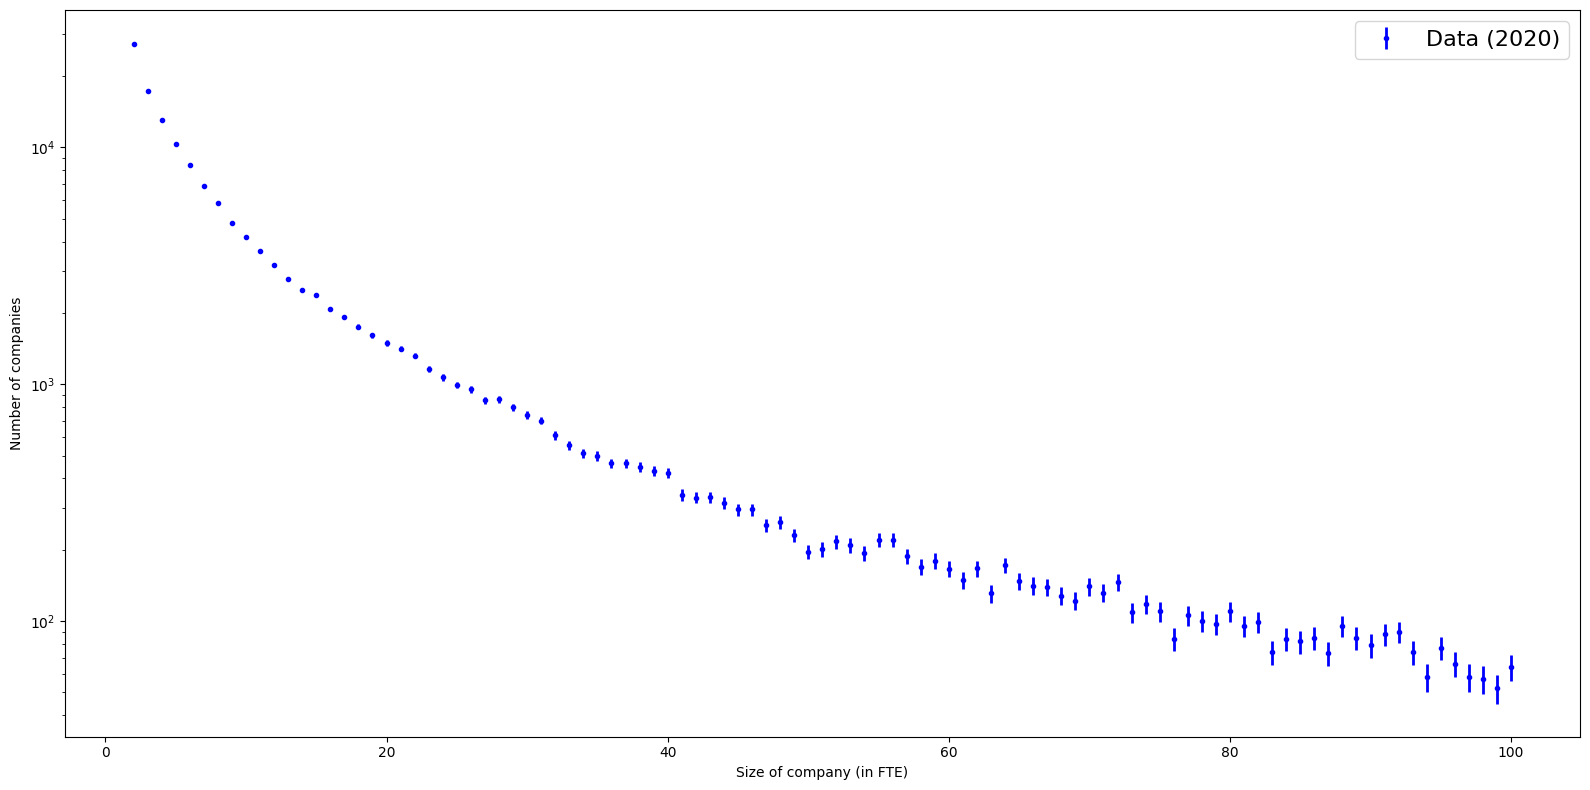

In [4]:
# Number of companies with a given size as a function of size:
fig_Ncompanies, ax_Ncompanies = plt.subplots(figsize=(16, 8))
ax_Ncompanies.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
ax_Ncompanies.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                  label='Data (2020)', color='blue')
ax_Ncompanies.legend(fontsize=16) #loc=(0.05, 0.75))

plt.yscale('log')
plt.tight_layout()
plt.show(block=False)

if (save_plots):
    plt.savefig("fig_DistNcompanies.pdf")

## Models

What is the best model for this distribution? Try the below models, and make better alternatives yourself.

In [5]:
# Power Law model:
def func_PowerLaw(x, N, alpha):
    return N * x ** (-alpha)

func_PowerLaw_vec = np.vectorize(func_PowerLaw)

In [6]:
# Exponential model:
def func_Exponential(x, N, alpha):
    return N * np.exp(-alpha * x)

func_Exponential_vec = np.vectorize(func_Exponential)

### Fit to data with Power Law


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N = 89687.68905 +/- 424.03597
Fit value (exp): alpha = 1.45003 +/- 0.00204
  Model fit:  Prob(Chi2=6644.7, Ndof= 97) = 0.00000


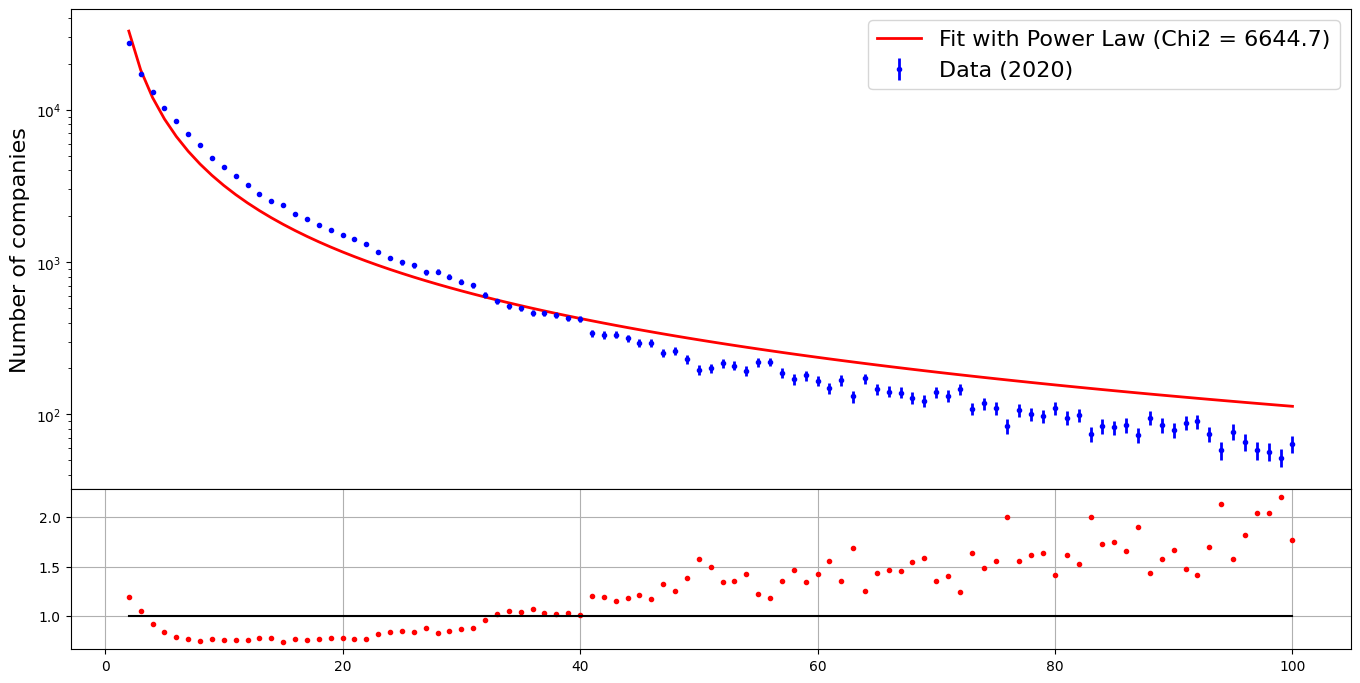

In [7]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit = plt.figure(figsize=(16, 8))
frame1 = fig_fit.add_axes((.1,.3,.8,.6))
plt.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
#ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
plt.xlabel( "Size of company (in FTE)",fontsize=16)
plt.ylabel("Number of companies",fontsize=16)
frame1.set_xticklabels([]) 
plt.yscale('log')


# Power Law fit:
# --------------
def ChiSquarePowerLaw(N, alpha):
    Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquarePowerLaw, N=50000.0, alpha=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies[minFit:maxFit]) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
plt.plot(Nworkers[minFit:maxFit], func_PowerLaw_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Power Law (Chi2 = {chi2:6.1f})')
plt.legend(fontsize=16);

# residual
ratio = func_PowerLaw_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit)/ Ncompanies[minFit:maxFit]
frame2 = fig_fit.add_axes((.1,.1,.8,.2))   
plt.plot(Nworkers[minFit:maxFit],ratio,'.', color="red")
plt.plot(Nworkers[minFit:maxFit],np.ones(len(Nworkers[minFit:maxFit])),'-', color="black")
plt.grid()

In [8]:
if (save_plots):
    plt.savefig("fig_NworkersInDKcompanies_FitPowerLaw.pdf")

### Fit data with exponential fit

Fit value (exp): N = 20800.75811 +/- 145.98809
Fit value (exp): alpha = 0.13385 +/- 0.00072
  Model fit:  Prob(Chi2=18797.5, Ndof=197) = 0.0000000000000000000000000


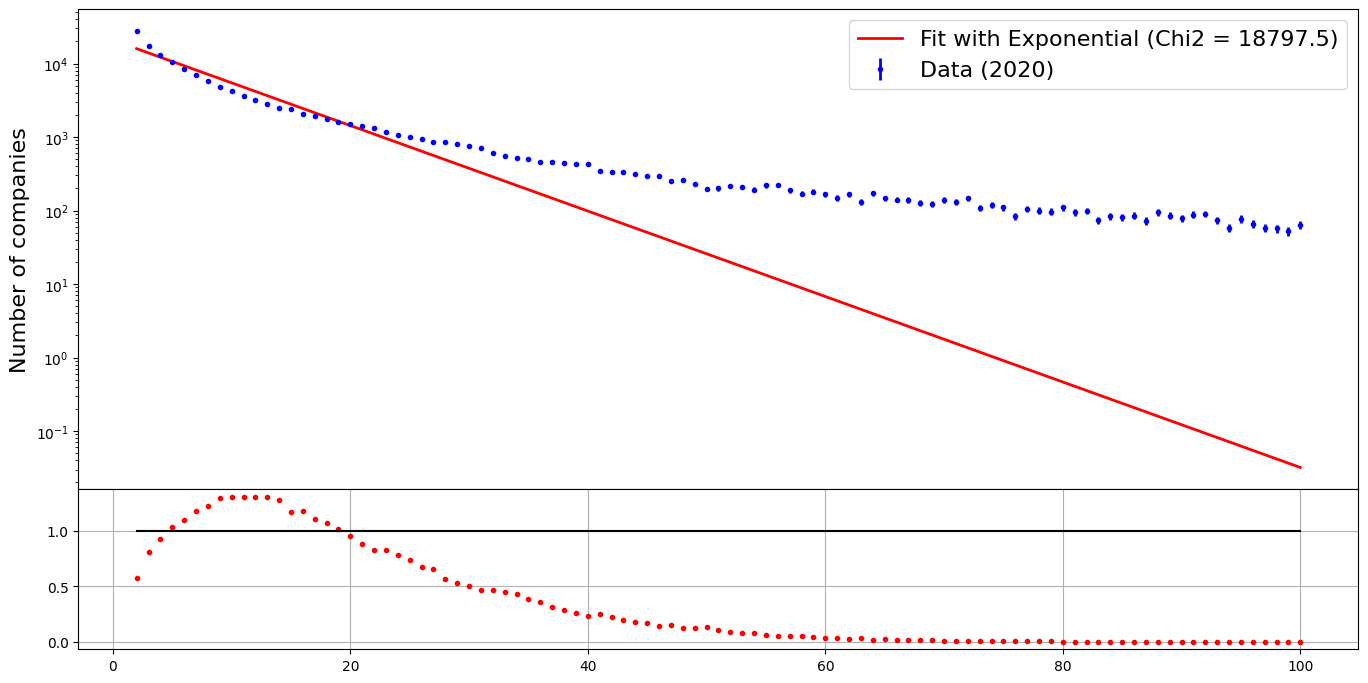

In [9]:
# Plot data points again
fig_fit = plt.figure(figsize=(16, 8))
frame1 = fig_fit.add_axes((.1,.3,.8,.6))
plt.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
#ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
plt.xlabel( "Size of company (in FTE)",fontsize=16)
plt.ylabel("Number of companies",fontsize=16)
frame1.set_xticklabels([]) 
plt.yscale('log')


# Exponential fit:
# ----------------
def ChiSquareExponential(N, alpha):
    Ncompanies_est = func_Exponential(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2


minuit = Minuit(ChiSquareExponential, N=50000.0, alpha=0.06)
minuit.errordef = 1.0
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Nworkers) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.25f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
plt.plot(Nworkers[minFit:maxFit], func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Exponential (Chi2 = {chi2:6.1f})')
plt.legend(fontsize=16);

# now for residual plot
difference = func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit)/ Ncompanies[minFit:maxFit]
frame2 = fig_fit.add_axes((.1,.1,.8,.2))        
plt.plot(Nworkers[minFit:maxFit],difference,'.', color="red")
plt.plot(Nworkers[minFit:maxFit],np.ones(len(Nworkers[minFit:maxFit])),'-', color="black")
plt.grid()

In [10]:
if (save_plots):
    plt.savefig("fig_NworkersInDKcompanies_FitExponential.pdf")

### Fit data with a combined power and exponential model

In [17]:
# Combined Power and Exponential model:
def func_PowExp(x, N, f, alphaPow, alphaExp):
    return N * (f * x ** (-alphaPow) + (1 - f) * np.exp(-alphaExp * x) / alphaExp)
func_PowExp_vec = np.vectorize(func_PowExp)

def plot_power(x, N, f, alphaPow):
    return N * f * x ** (-alphaPow)
func_plot_power_vec = np.vectorize(plot_power)

def plot_exp(x, N, f, alphaExp):
    return N * f * np.exp(-alphaExp * x)
func_plot_exp_vec = np.vectorize(plot_exp)

Fit value (exp): N = 63638.99231 +/- 724.37785
Fit value (exp): f = 0.98854 +/- 0.00048
Fit value (exp): alphaPow = 1.46683 +/- 0.00481
Fit value (exp): alphaExp = 0.11020 +/- 0.00144
  Model fit:  Prob(Chi2= 373.6, Ndof=195) = 0.000000000000240


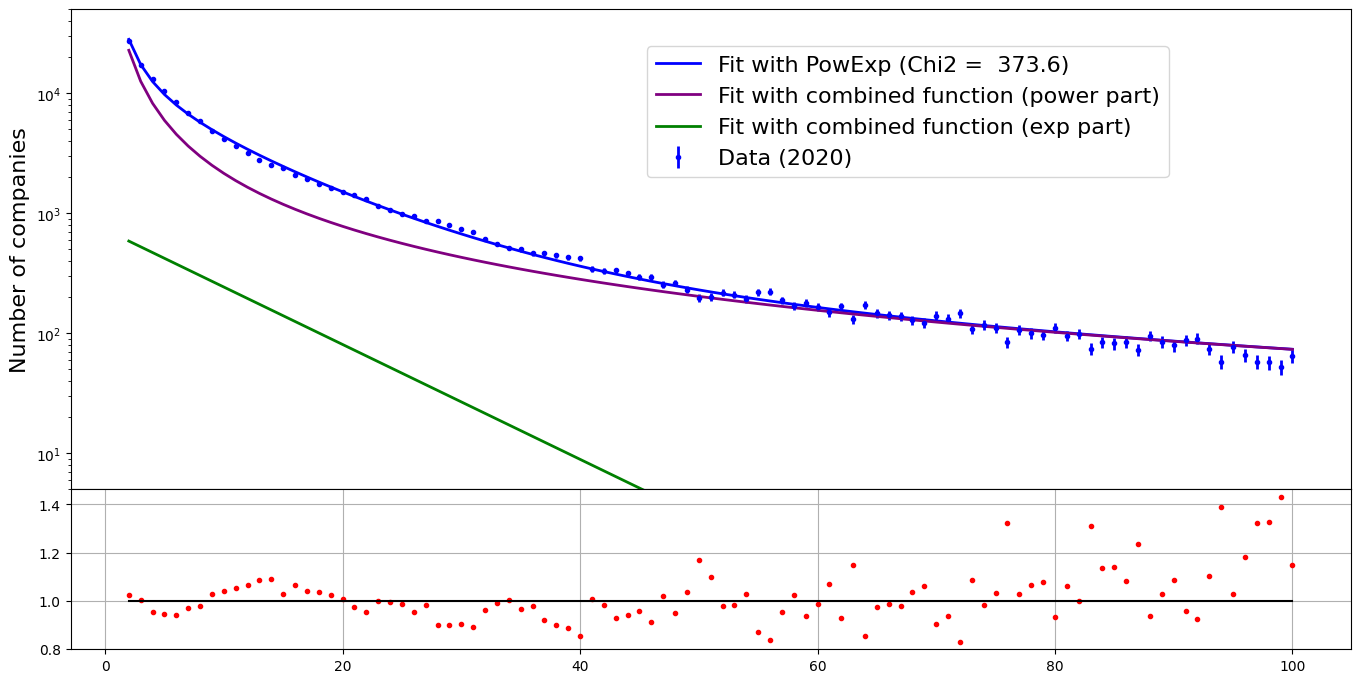

In [23]:
# Plot data points again
fig_fit = plt.figure(figsize=(16, 8))
frame1 = fig_fit.add_axes((.1,.3,.8,.6))
plt.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
#ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
plt.xlabel( "Size of company (in FTE)",fontsize=16)
plt.ylabel("Number of companies",fontsize=16)
frame1.set_xticklabels([]) 
plt.yscale('log')

# PowExp fit:
# ----------------
def ChiSquarePowExp(N, f, alphaPow, alphaExp):
    Ncompanies_est = func_PowExp(Nworkers[minFit:maxFit], N, f, alphaPow, alphaExp)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2


minuit = Minuit(ChiSquarePowExp, N=50000.0, f=0.5, alphaPow=2.0, alphaExp=0.06)
minuit.errordef = 1.0
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Nworkers) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:.15f}")

N_fit, f_fit, alphaPow_fit, alphaExp_fit = minuit.values[:]
eN_fit, ef_fit, ealphaPow_fit, ealphaExp_fit = minuit.errors[:]
plt.plot(Nworkers[minFit:maxFit], func_PowExp_vec(Nworkers[minFit:maxFit], N_fit, f_fit, alphaPow_fit, alphaExp_fit), 'blue',
            linewidth=2.0, label=f'Fit with PowExp (Chi2 = {chi2:6.1f})')
plt.plot(Nworkers[minFit:maxFit], func_plot_power_vec(Nworkers[minFit:maxFit], N_fit, f_fit, alphaPow_fit), 'purple', linewidth=2.0,
            label=f'Fit with combined function (power part)' )
plt.plot(Nworkers[minFit:maxFit], func_plot_exp_vec(Nworkers[minFit:maxFit], N_fit, 1.0-f_fit, alphaExp_fit), 'green', linewidth=2.0,
            label=f'Fit with combined function (exp part)' )


# Finalise the plot:
plt.legend(loc=(0.45, 0.65), fontsize=16)
# plt.set_yscale('log')
# fig_fit.tight_layout()
plt.ylim(5,50000)
fig_fit

ratio = func_PowExp_vec(Nworkers[minFit:maxFit], N_fit, f_fit, alphaPow_fit, alphaExp_fit)/Ncompanies[minFit:maxFit]
frame2 = fig_fit.add_axes((.1,.1,.8,.2))                        # Make box for residual     
plt.plot(Nworkers[minFit:maxFit], ratio, '.', color="red")      # Plotting the residual
plt.plot(Nworkers[minFit:maxFit], np.ones(len(Nworkers[minFit:maxFit])), "-", color= "black")
plt.grid()

# Questions

1. Try to fit the data (in the range 1-100) with a power law, an exponential, and a combination of the two. Are you satisfied with the results?

_Example solution 1_: The combination of an exponential and a power law gives better results than the individual exponential or power law fits, although the results are still not fantastic ($\chi^2 = 374$ and p-value $= 2 \times 10^{-13}$). However, given the high statistics behind the histogram, it is not surprising that such a simple model (4 parameters) does not fit perfectly. The residuals show that the typical deviation of the model from the data is 5-7%, which seems OK for a model spanning more than two orders of magnitude.

2. Can you think of any other function that would fit throught the data better? Try to expand on the functions by adding more complexity and parameters, and see how well you can do. Do you manage to reach a "good" model, and how would you define one such?

_Example solution 2_: This is where we threw in the towel, but if you managed to find a function that fits the data better we would love to see your results! A better model can be defined by a lower $\chi^2$ and higher p-value.

3. From a "good" fit, try to predict how many companies there are with 101-150 employes. Compare this number to the data, and see how well you manage.

_Example solution 3_: In order to predict the number of companies using your best fit model, calculate its predictions (y-values) for companies with 101, 102, 103, 104 and 105 employees (x-values), and sum these values. Compare this to the actual numbers from the data. In our case, this lead to a relative prediction error of 25%.
An improved prediction can be gotten by NOT fitting the very first of the spectrum, as this is irrelevant to the question, while those in the range 10-100 are more relevant.